### Data Wrangling

In [228]:
import pandas as pd
import cvxpy as cp
import seaborn as sns
from scipy.stats import linregress
import matplotlib.pyplot as plt

Since the data has been separated into two timeslots, we will combine them together.

Meanwhile, the data has been classified into units of daily and hourly, and we will list them respectively.

In [229]:
# Load datasets
daily_activity_1 = pd.read_csv('data/daily/dailyActivity_merged_1.csv')

daily_activity_2 = pd.read_csv('data/daily/dailyActivity_merged_2.csv')

hourly_calories_1 = pd.read_csv('data/hourly/hourlyCalories_merged_1.csv')
hourly_intensities_1 = pd.read_csv('data/hourly/hourlyIntensities_merged_1.csv')
hourly_steps_1 = pd.read_csv('data/hourly/hourlySteps_merged_1.csv')

hourly_calories_2 = pd.read_csv('data/hourly/hourlyCalories_merged_2.csv')
hourly_intensities_2 = pd.read_csv('data/hourly/hourlyIntensities_merged_2.csv')
hourly_steps_2 = pd.read_csv('data/hourly/hourlySteps_merged_2.csv')

In [230]:
# Concatenate datasets

daily_activity = pd.concat([daily_activity_1, daily_activity_2], ignore_index=True)

hourly_calories = pd.concat([hourly_calories_1, hourly_calories_2], ignore_index=True)
hourly_intensities = pd.concat([hourly_intensities_1, hourly_intensities_2], ignore_index=True)
hourly_steps = pd.concat([hourly_steps_1, hourly_steps_2], ignore_index=True)

# Merge datasets
merged_data = pd.merge(hourly_calories, hourly_intensities, on=['Id', 'ActivityHour'])
merged_data = pd.merge(merged_data, hourly_steps, on=['Id', 'ActivityHour'])

# Reorder columns
hourly_activity = merged_data[['Id', 'ActivityHour', 'Calories', 'TotalIntensity', 'AverageIntensity', 'StepTotal']]

We will save the merged datasets for copies.

In [231]:
daily_activity.to_csv("data/daily_data.csv", index=False)
daily_activity = daily_activity.sort_values(by=['Id', 'ActivityDate'])

hourly_activity.to_csv("data/hourly_data.csv", index=False)
hourly_activity = hourly_activity.sort_values(by=['Id', 'ActivityHour'])

Now we preview the cleaned datasets.

In [232]:
daily_activity.head()

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,1503960366,3/25/2016,11004,7.11,7.11,0.0,2.57,0.46,4.07,0.0,33,12,205,804,1819
1,1503960366,3/26/2016,17609,11.55,11.55,0.0,6.92,0.73,3.91,0.0,89,17,274,588,2154
2,1503960366,3/27/2016,12736,8.53,8.53,0.0,4.66,0.16,3.71,0.0,56,5,268,605,1944
3,1503960366,3/28/2016,13231,8.93,8.93,0.0,3.19,0.79,4.95,0.0,39,20,224,1080,1932
4,1503960366,3/29/2016,12041,7.85,7.85,0.0,2.16,1.09,4.61,0.0,28,28,243,763,1886


In [233]:
hourly_activity.head()

,Id,ActivityHour,Calories,TotalIntensity,AverageIntensity,StepTotal
10,1503960366,3/12/2016 10:00:00 AM,89,26,0.433333,551
22,1503960366,3/12/2016 10:00:00 PM,123,41,0.683333,1132
11,1503960366,3/12/2016 11:00:00 AM,134,49,0.816667,1764
23,1503960366,3/12/2016 11:00:00 PM,111,35,0.583333,918
0,1503960366,3/12/2016 12:00:00 AM,48,0,0.000000,0


### Issue

Lacking sleeping data for the first half

### Solving ways

Playing around data to find the sleeping slot.

### Define LP Problem

- Define Decision Variables
    - We'll define decision variables to represent the time spent on each activity (e.g. Very active, Moderately active, Light active, Sedentary) daily.
- Define Objective Function
    - We'll maximize the total calories burned. It's based on the following:
        - Time spending on each activity.
        - Corresponding calories burned per hour.
- Add constraints
    - We will add constraints to ensure that the total time spent on all activities in a day does not exceed *$24 - 8 = 16$ 'assumed sleeping time'* hours.
    - We may have constraints such as min & max time limits for each activity types. 

### SAMPLE CASE

Data analysis

In [234]:
# Convert date and time columns to datetime format for better manipulation
daily_activity['ActivityDate'] = pd.to_datetime(daily_activity['ActivityDate'])
hourly_activity['ActivityHour'] = pd.to_datetime(hourly_activity['ActivityHour'])

# Sort daily_data by 'Id' and 'ActivityDate' if the IDs are not grouped together
daily_data_sorted = daily_activity.sort_values(by=['Id', 'ActivityDate'])

# Calculate average calories burned by different activity intensities in daily data
activity_columns = ['VeryActiveMinutes', 'FairlyActiveMinutes', 'LightlyActiveMinutes', 'SedentaryMinutes']
daily_activity['TotalActiveMinutes'] = daily_activity[activity_columns].sum(axis=1)
for activity in activity_columns:
    daily_activity[f'{activity}Calories'] = (daily_activity[activity] / daily_activity['TotalActiveMinutes']) * daily_activity['Calories']
average_calories_per_activity = daily_activity[[f'{activity}Calories' for activity in activity_columns]].mean()

# Analysis of hourly calorie burn pattern
# Group the data by hour and calculate the average calorie burn
hourly_calories_burned = hourly_activity.groupby(hourly_activity['ActivityHour'].dt.hour)['Calories'].mean()

Visualization

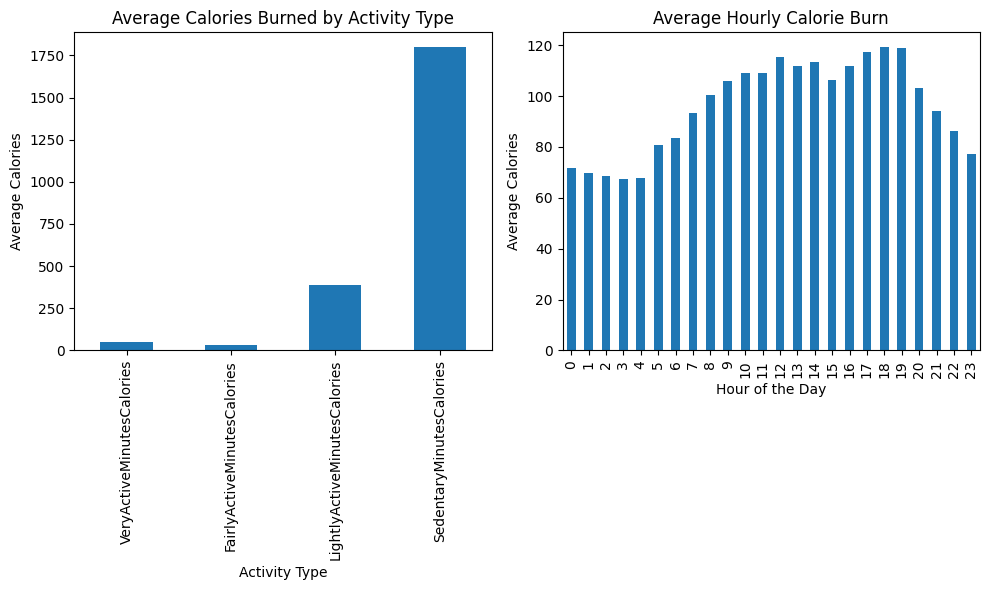

In [235]:
plt.figure(figsize=(10, 6))

# Visualize the average calories burned by activity type
plt.subplot(1, 2, 1)
average_calories_per_activity.plot(kind='bar')
plt.title('Average Calories Burned by Activity Type')
plt.ylabel('Average Calories')
plt.xlabel('Activity Type')


# Visualize the average hourly calorie burn
plt.subplot(1, 2, 2)
hourly_calories_burned.plot(kind='bar')
plt.title('Average Hourly Calorie Burn')
plt.ylabel('Average Calories')
plt.xlabel('Hour of the Day')

plt.tight_layout()
plt.show()

While sedentary activities show a high average calorie burn, this primarily reflects the extended duration of these activities rather than a higher efficiency in burning calories. 

Active minutes are far more effective at burning calories on a per-minute basis and are crucial for health and fitness, despite contributing less to the total daily calorie count due to their shorter duration.

### Optimization Problem Formulation

We aim to maximize the total calories burned through various activities within a 24-hour period. This problem can be framed as a Linear Programming (LP) model.

#### Decision Variables
- $x_1$: Hours spent in very active activities
- $x_2$: Hours spent in fairly active activities
- $x_3$: Hours spent in lightly active activities
- $x_4$: Hours spent in sedentary activities

#### Objective Function
Maximize total calories burned:
$$
\text{Maximize } Z = c_1 \cdot x_1 + c_2 \cdot x_2 + c_3 \cdot x_3 + c_4 \cdot x_4
$$
where $c_i$ represents the calories burned per hour from activity $i$.

#### Constraints
1. The sum of hours spent in all activities should not exceed 24 hours.
$$
x_1 + x_2 + x_3 + x_4 \leq 24
$$
2. Each decision variable must be non-negative (can't spend negative time in an activity).
$$
x_1, x_2, x_3, x_4 \geq 0
$$

The solution to this LP model will provide the optimal distribution of time across activities to maximize calorie burn.

In [236]:
# Define the decision variables
x1 = cp.Variable()  # Very active hours
x2 = cp.Variable()  # Fairly active hours
x3 = cp.Variable()  # Lightly active hours
x4 = cp.Variable()  # Sedentary hours

# Coefficients (calories burned per hour for each activity)
c1, c2, c3, c4 = 50.5, 31.5, 387.4, 1796.8

# Objective function (Maximize total calories burned)
objective = cp.Maximize(c1 * x1 + c2 * x2 + c3 * x3 + c4 * x4)

# Constraints
constraints = [
    x1 + x2 + x3 + x4 <= 24,  # Total hours in a day
    x1 >= 0, x2 >= 0, x3 >= 0, x4 >= 0  # Non-negative hours
]

# Define and solve the problem
problem = cp.Problem(objective, constraints)
problem.solve()

# Output the optimized solution
print("Very active hours:", x1.value)
print("Fairly active hours:", x2.value)
print("Lightly active hours:", x3.value)
print("Sedentary hours:", x4.value)
print("Total calories burned:", problem.value)

Very active hours: 6.654351053348774e-09
Fairly active hours: 6.619085069649471e-09
Lightly active hours: 7.088027532722796e-09
Sedentary hours: 23.999999973078932
Total calories burned: 43123.19995491867


c:\Users\rocky\miniconda3\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


The result doesn't scientifically make sense at all.

However, these are just a try-out to see the accessibility of `cvxpy` and it works well so far.

Now we will make a deeper observation into the data.

### Adding common sense constraints

- Define total available time for activities:
    - Assuming 8 hours of sleep, we have 16 hours left for all other activities.

- Set realistic time constraints for each activities:
    - Based on average behaviors or recommended guidlines, define the max and min hours for each activities.

- $$ x_1 + x_2 + x_3 + x_4 \leq 24 - 8 = 16 $$
    - $$ 0 \leq x_1 \leq 3$$
    - $$ 0 \leq x_2 \leq 4$$
    - $$ 0 \leq x_3 \leq 6$$
    - $$ 0 \leq x_4 \leq 8$$ 
    (including general low-intensity activities and rest)

In [237]:
# Objective function
objective = cp.Maximize(c1 * x1 + c2 * x2 + c3 * x3 + c4 * x4)

# Constraints
constraints = [
    x1 + x2 + x3 + x4 <= 16,  # Adjusted for 8 hours of sleep
    0 <= x1, x1 <= 3,  # Very Active time constraint
    0 <= x2, x2 <= 4,  # Fairly Active time constraint
    0 <= x3, x3 <= 6,  # Lightly Active time constraint
    0 <= x4, x4 <= 8,  # Sedentary time constraint
]

# Solve the problem
problem = cp.Problem(objective, constraints)
problem.solve()

# Display results
print(f"Very Active hours: {x1.value}")
print(f"Fairly Active hours: {x2.value}")
print(f"Lightly Active hours: {x3.value}")
print(f"Sedentary hours: {x4.value}")
print(f"Total calories burned: {problem.value}")

Very Active hours: 1.9999999605791374
Fairly Active hours: 1.5304593555433914e-08
Lightly Active hours: 5.999999984742066
Sedentary hours: 7.999999998998718
Total calories burned: 16799.799990781314


Now the data is giving a relatively reasonable results:
- $\approx 2$ very active hours
- $\approx 0$ fairly active hours
- $\approx 6$ lightly active hours
- $\approx 8$ sedentary hours
- $\approx 16800$ total calories burned.

#### Meaningful decision variable, objective, constraints exploration

Since daily activites from `fitbit` is not the only source of the routine, we will also consider other factors:
- `gym exercise` $\to$ `calories burning from training`
- `diet` $\to$ `calories absorption from diet` 

We will firstly do some data analysis to see the distributions and trends to deliver an overview for the next step.

C:\Users\rocky\AppData\Local\Temp\ipykernel_20324\1197827604.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  exercise_dataset.groupby('Intensity')['AverageCalories'].mean().plot(kind='bar')


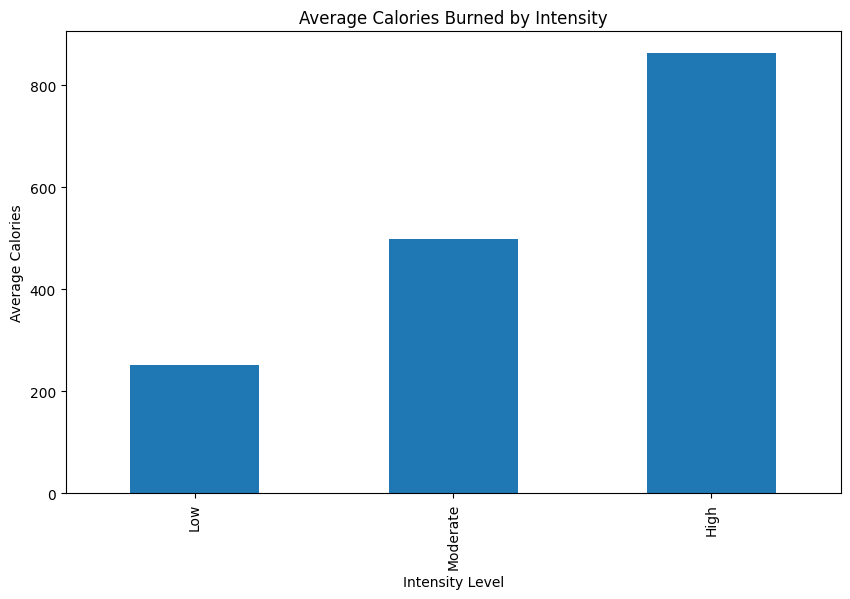

In [238]:
# Categorize activities based on calorie burn rate

# Load the exercise dataset
exercise_dataset = pd.read_csv('data/exercise_dataset.csv')

# Calculate the average calories burned across different weights
exercise_dataset['AverageCalories'] = exercise_dataset[['130 lb', '155 lb', '180 lb', '205 lb']].mean(axis=1)

# Categorize activities based on average calorie burn rate
low_threshold = exercise_dataset['AverageCalories'].quantile(0.33)
high_threshold = exercise_dataset['AverageCalories'].quantile(0.66)

exercise_dataset['Intensity'] = pd.cut(exercise_dataset['AverageCalories'],
                                       bins=[0, low_threshold, high_threshold, exercise_dataset['AverageCalories'].max()],
                                       labels=['Low', 'Moderate', 'High'])

# Plotting the average calories by intensity
plt.figure(figsize=(10, 6))
exercise_dataset.groupby('Intensity')['AverageCalories'].mean().plot(kind='bar')
plt.title('Average Calories Burned by Intensity')
plt.ylabel('Average Calories')
plt.xlabel('Intensity Level')
plt.show()

From the graph above:
- Variables:
    - Time spent on activities of low, moderate, and high intensities.
- Constraints:
    - A realistic cap on time that can be spent on high-intensity activities due to physical limitations.
    - Min and Max time allocations for each intensity level to ensure a balanced exercise regimen.

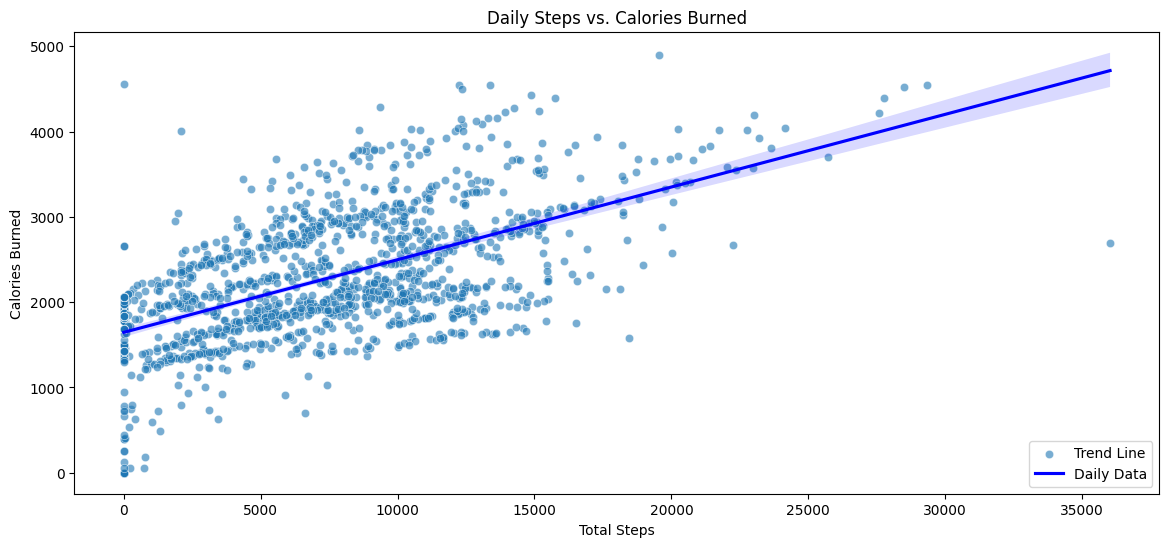

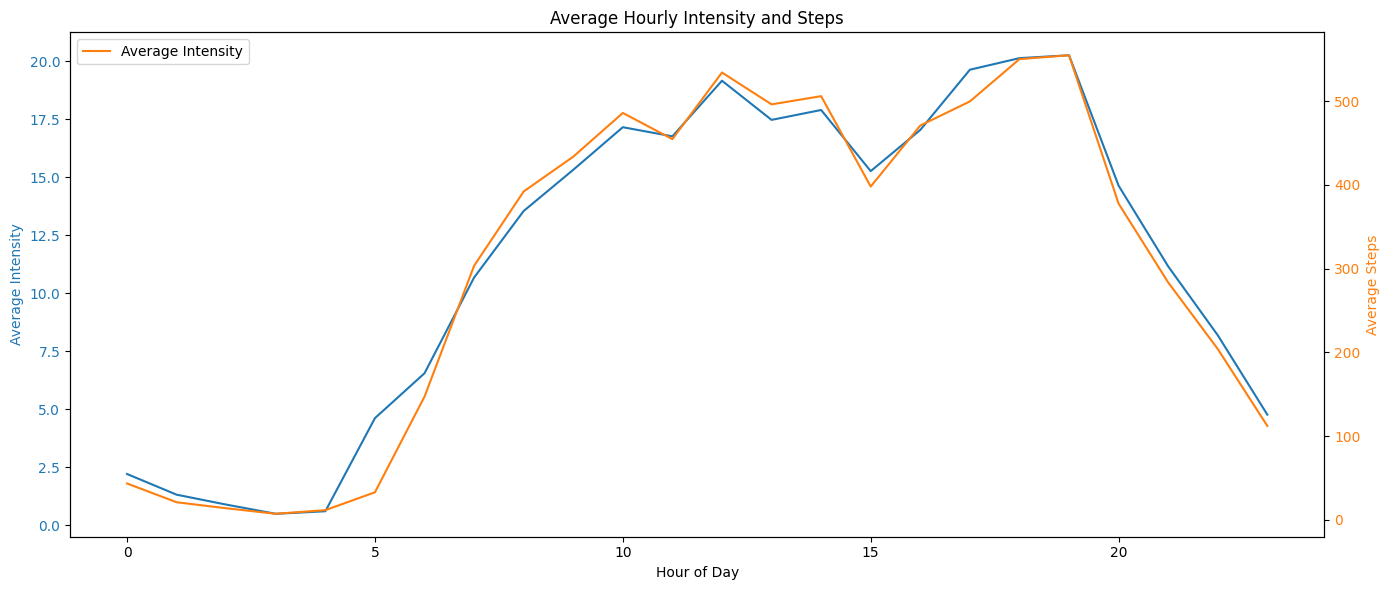

In [239]:
# analyse activity distribution and sedentary v.s. active time

# Scatter plot for daily steps and calories burned
plt.figure(figsize=(14, 6))
sns.scatterplot(x='TotalSteps', y='Calories', data=daily_activity, alpha=0.6)

# Adding a trend line
sns.regplot(x='TotalSteps', y='Calories', data=daily_activity, scatter=False, color='blue')

plt.title('Daily Steps vs. Calories Burned')
plt.xlabel('Total Steps')
plt.ylabel('Calories Burned')
plt.legend(['Trend Line', 'Daily Data'])
plt.show()

# Assuming 'ActivityHour' is a datetime column and we want to extract the hour part
hourly_activity['Hour'] = pd.to_datetime(hourly_activity['ActivityHour']).dt.hour

# Select only numeric columns for averaging
numeric_cols = hourly_activity.select_dtypes(include=['number']).columns
average_hourly_data = hourly_activity.groupby('Hour')[numeric_cols].mean()

# Plotting average hourly intensity and steps with clear legends and axis labels
fig, ax1 = plt.subplots(figsize=(14, 6))

color = 'tab:blue'
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Average Intensity', color=color)
ax1.plot(average_hourly_data.index, average_hourly_data['TotalIntensity'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  
color = 'tab:orange'
ax2.set_ylabel('Average Steps', color=color)  
ax2.plot(average_hourly_data.index, average_hourly_data['StepTotal'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Title and legend
plt.title('Average Hourly Intensity and Steps')
fig.tight_layout()  # To ensure the right y-label is not slightly clipped
plt.legend(['Average Intensity', 'Average Steps'], loc='upper left')
plt.show()

From the first graph above:
- Variables:
    - The number of steps can be a proxy for certain types of activity levels.
- Objective Functions:
    - Calorie burn seems to correlate with the number of steps, so we want to maximize the function.
- Constraints:
    - A realistic maximum on daily steps, which could be related to the available time or physical fitness level.
    - Min step count to ensure enough daily activity.

From the second graph above:
- Variables:
    - Different activities spread across various hours of the day.
- Constraints:
    - Specific time of the day where physical activity is feasible (e.g., outside of working hours).
    - Varied activity intensities throughout the day to avoid fatigue and overtraining.

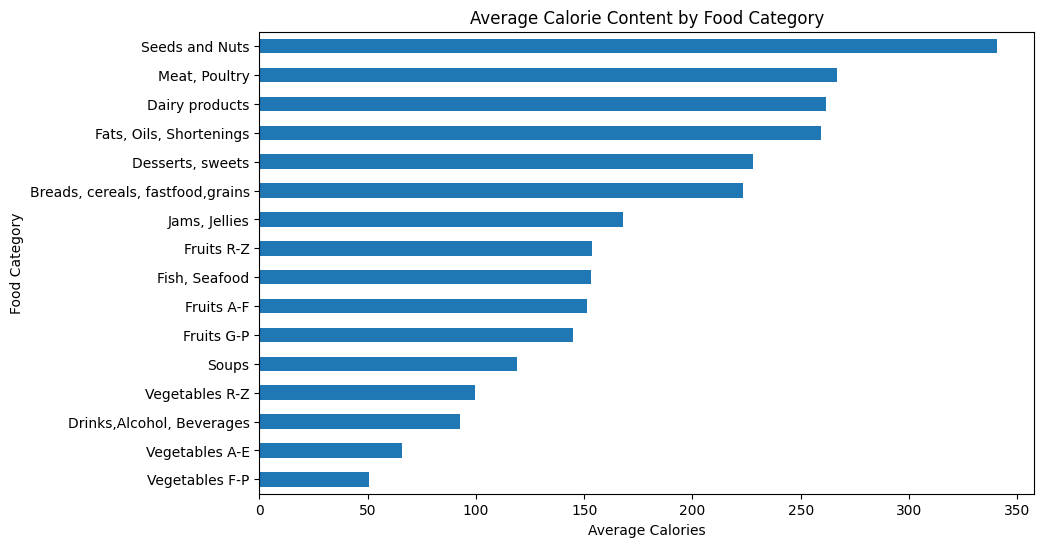

In [240]:
# Nutrient intake data

# Load the nutrients data
nutrients_data = pd.read_csv('data/nutrients_csvfile.csv')

# Cleaning and preparing the data
nutrients_data['Calories'] = pd.to_numeric(nutrients_data['Calories'], errors='coerce')

# Plotting the calorie content of different food categories
plt.figure(figsize=(10, 6))
nutrients_data.groupby('Category')['Calories'].mean().sort_values().plot(kind='barh')
plt.title('Average Calorie Content by Food Category')
plt.xlabel('Average Calories')
plt.ylabel('Food Category')
plt.show()

From the graph above:
- Variables:
    - Types and quantities of food consumed.
- Constraints:
    - Dietary restrictions or preferences can be included as constraints.
    - Total caloric intake should be in balance with calories burned to maintain, lose, or gain weight as per goals.

#### Notes before LP Set Up:

- Overlap between walking steps and low/moderate-intensity activites:
    - Since steps can be a proxy for various activities, we can decide to either count them separately or include them in the calculation of calories burned for low/moderate-intensity activities.
- Intensity level separation:
    - We'll analyze the `hourly_data` dataset to categorize total intensity into low, moderate, and high levels. Then, we'll match these categories with the corresponding activities and calorie burn rates from the `exercise_dataset`.
- Real-world practical conditions:
    - Consider factors such as work hours, meals, and rest times, ensuring the time allocated to activities is realistic.
    - Set limits on the duration of continuous high-intensity exercise to prevent over-exertion.

In [241]:
# Due to failure of implementing total_intensity level separation right away
# We suspect that it is due to some internal issue of the dataset

# Let's assume there are a significant number of zero values
zero_intensity_count = (hourly_activity['TotalIntensity'] == 0).sum()

# If there are a lot of zero values, create a separate bin for them
if zero_intensity_count > len(hourly_activity) * 0.1:  # if more than 10% are zeros
    bins = [0, 0.1]  # This bin captures zero values
    quantiles = hourly_activity[hourly_activity['TotalIntensity'] > 0.1]['TotalIntensity'].quantile([0.33, 0.66])
    bins.extend(quantiles)
    bins.append(hourly_activity['TotalIntensity'].max())
else:
    # Otherwise, create bins based on quantiles, excluding zero if it's a duplicate
    quantiles = hourly_activity['TotalIntensity'].quantile([0.33, 0.66, 1.0]).tolist()
    bins = [0] + quantiles

# Deduplication and sorting
bins = sorted(set(bins))

# Ensure there are at least two bins besides zero to categorize the data
if len(bins) < 4:
    raise ValueError("Insufficient unique intensity values to categorize. Consider custom bin definitions.")

# Use cut to categorize intensity levels
hourly_activity['IntensityLevel'] = pd.cut(hourly_activity['TotalIntensity'], 
                                       bins=bins, 
                                       labels=['None', 'Low', 'Moderate', 'High'], 
                                       include_lowest=True)

# Check for NaN values in the 'IntensityLevel' column
if hourly_activity['IntensityLevel'].isnull().any():
    raise ValueError("NaN values in 'IntensityLevel' after binning, adjust your bins.")

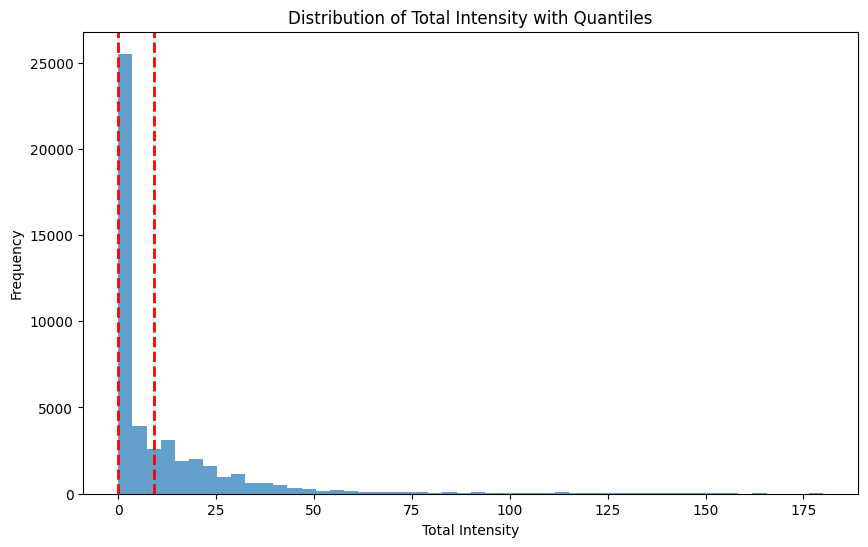

In [242]:
# Plot a histogram of the 'TotalIntensity' data
plt.figure(figsize=(10, 6))
plt.hist(hourly_activity['TotalIntensity'], bins=50, alpha=0.7)

# Calculate quantiles and add them to the histogram as vertical lines
quantiles = hourly_activity['TotalIntensity'].quantile([0.33, 0.66])
for quantile in quantiles:
    plt.axvline(quantile, color='r', linestyle='dashed', linewidth=2)

plt.title('Distribution of Total Intensity with Quantiles')
plt.xlabel('Total Intensity')
plt.ylabel('Frequency')

# Show the plot with quantiles
plt.show()

#### LP Model Set Up:

We can define an LP problem where the objective is to maximize the total calories burned through activity, while keeping within nutritional and time constraints.

- Decision Variables:
    - $x_l, x_m, x_h$ be the hours spent on low, moderate, and high intensity activities respectively.
    - $c$ be the total calories consumed from food.
- Objective Functions:
    - $Maximize Z = cal_l*x_l + cal_m*x_m + cal_h*x_h - c$
- Constraints:
    - Total time spent on activities doesn't exceed the number of waking hours minus time for other daily responsibilities.
        - $x_l+x_m+x_h \leq 24 - 8(work) - 1(meal) - 8(sleep) = 7$
    - Time spent on high-intensity activities is capped at a level consistent with good health practices.
        - $x_h \leq 1$
    - Time spent on high/moderate-intensity activities is guaranteed essentially.
        - $x_m + x_h \geq 1$
    - Caloric intake from food doesn't exceed a certain limit if the goal is weight maintenance or loss.
        - $c \leq 2300 + cal_l*x_l + cal_m*x_m + cal_h*x_h$
            - $2300$ is based on the fact of *adult females are likely to require between 1600-2400 calories a day,and adult males from 2200-3000*. We then take the intersection of the range as ideal index.
        - $c \geq c_{BMR}$, where BMR stands for Basal Metabolic Rate.
            - Since we don't have specific data about users' weight, height, etc. We will select a general numerical result for majority. Based on investigation, $1650$ would be an ideal number.
    - General constraints:
        - $x_m, x_h, c \geq 0, x_l \geq 1 (rest)$

In [243]:
# Based on the exercise dataset
# We get the hourly calories consuming based on intensity.
average_calories_by_intensity = exercise_dataset.groupby('Intensity')['AverageCalories'].mean()
print(average_calories_by_intensity)

Intensity
Low         251.734756
Moderate    498.729167
High        862.715517
Name: AverageCalories, dtype: float64


C:\Users\rocky\AppData\Local\Temp\ipykernel_20324\1120180857.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_calories_by_intensity = exercise_dataset.groupby('Intensity')['AverageCalories'].mean()


In [244]:
# Define the variables
x_l = cp.Variable()  # Hours spent on low-intensity activities
x_m = cp.Variable()  # Hours spent on moderate-intensity activities
x_h = cp.Variable()  # Hours spent on high-intensity activities
c = cp.Variable() # Consumed calories

cal_l = 251.733756
cal_m = 498.729167
cal_h = 862.715517
C_maintenance = 2300  # Daily maintenance calorie level
C_bmr = 1650

# Total time available for exercise (in hours)
T_available = 7
# Maximum duration of high-intensity exercise (in hours)
H_max = 1

# Constraints
constraints = [
    x_l + x_m + x_h <= T_available,
    x_h <= H_max,
    c <= C_maintenance + (cal_l*x_l + cal_m*x_m + cal_h*x_h),
    # Ensure at least some moderate to high-intensity exercise is performed
    x_m + x_h >= 1,
    # Non-negativity constraints
    x_l >= 1,
    x_m >= 0,
    x_h >= 0,
    c >= C_bmr,
]

# Objective function
objective = cp.Maximize(cal_l*x_l + cal_m*x_m + cal_h*x_h - c)

# Solve the problem
problem = cp.Problem(objective, constraints)
problem.solve()

# Output the results
print(f"Time on low-intensity activities: {x_l.value} hours")
print(f"Time on moderate-intensity activities: {x_m.value} hours")
print(f"Time on high-intensity activities: {x_h.value} hours")
print(f"Calories consumed: {c.value}")

Time on low-intensity activities: 1.0000000003255587 hours
Time on moderate-intensity activities: 5.000000000120425 hours
Time on high-intensity activities: 0.9999999997654634 hours
Calories consumed: 1650.000000453656


c:\Users\rocky\miniconda3\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


In [245]:
print(cal_l*x_l.value + cal_m*x_m.value + cal_h*x_h.value - c.value)

1958.095107486019


Based on the result, we could get the result:
- $\approx 1$ hours of low-intensity activities.
- $\approx 5$ hours of moderate-intensity activities.
- $\approx 1$ hours of high-intensity activities.
- $\approx 1650$ calories consumed from food.

$\approx 1$ hours of low-intensity activities is a little concerning, since we could suspect that `walking`, one of the most general way of exercise, is omitted if it is classified as low-intensity activity.

In [246]:
# Look for 'Walking' in the 'Activity' column and check its categorization
walking_intensity = exercise_dataset[exercise_dataset['Activity, Exercise or Sport (1 hour)'].str.contains("Walking", case=False, na=False)]['Intensity'].values

# Check if the array is not empty and then print the result
if walking_intensity:
    print(f"Walking is categorized as: {walking_intensity[0]} intensity.")
else:
    print("Walking is not explicitly categorized in the dataset.")

Walking is categorized as: Moderate intensity.


Since walking is generally classified as moderate intensity, the result makes sense.

### Improvement (Fine Tuning)

Since we have gotten a general optimized time split for maximizing daily calories burning, we would like to fine tune it to seek a more optimized solution.

We will look into `moderate intensity activities` since `walking`, one of the most important activites, is included.

We will also look into `high intensity activities` for seeking a better solution.

The way we check whether the new solution is better or not is to compare itself with the $hour\_spending * average\_of\_calories\_burning$.

Now we focusing on getting some numerical details from the `walking`-related graphs we've visualized above.

In [247]:
regression_results = linregress(daily_activity['TotalSteps'], daily_activity['Calories'])
regression_results

LinregressResult(slope=0.08522536579920388, intercept=1645.7483435429426, rvalue=0.5901599477780501, pvalue=7.269987389738127e-132, stderr=0.0031213296833828624, intercept_stderr=27.949641478647564)

In [248]:
# Convert the 'ActivityHour' to a datetime object and extract the hour
hourly_activity['Hour'] = pd.to_datetime(hourly_activity['ActivityHour']).dt.hour
# Calculate the average intensity and steps for each hour
average_hourly_data = hourly_activity.groupby('Hour')['AverageIntensity'].mean()

average_hourly_data

# Assume non-working hours are from 5pm to 10pm (17 to 22)
walking_hours = average_hourly_data.loc[17:22]
# Consider a threshold for walking intensity
walking_threshold = walking_hours.quantile(0.75)
# Identify the hours suitable for walking
suitable_walking_hours = walking_hours[walking_hours <= walking_threshold]
print(f"Suitable hours for walking: {suitable_walking_hours.index.tolist()}")

Suitable hours for walking: [17, 20, 21, 22]


In [249]:
# First, we'll sort the moderate intensity activities
moderate_intensity = exercise_dataset[exercise_dataset['Intensity'] == 'Moderate'].copy()
moderate_intensity_sorted = moderate_intensity.sort_values('AverageCalories', ascending=False)

# Then, sort the high intensity activities
high_intensity = exercise_dataset[exercise_dataset['Intensity'] == 'High'].copy()
high_intensity_sorted = high_intensity.sort_values('AverageCalories', ascending=False)

# Omit minorities temporarily for majority
moderate_intensity_sorted = moderate_intensity_sorted[~moderate_intensity_sorted['Activity, Exercise or Sport (1 hour)'].str.contains('wheelchair|officiating|crutches')]
high_intensity_sorted = high_intensity_sorted[~high_intensity_sorted['Activity, Exercise or Sport (1 hour)'].str.contains('wheelchair|officiating|crutches')]

# Output the rankings
print("Moderate Intensity Activities Ranked by Calories Burned:")
print(moderate_intensity_sorted[['Activity, Exercise or Sport (1 hour)', 'AverageCalories']])

print("\nHigh Intensity Activities Ranked by Calories Burned:")
print(high_intensity_sorted[['Activity, Exercise or Sport (1 hour)', 'AverageCalories']])

Moderate Intensity Activities Ranked by Calories Burned:
    Activity, Exercise or Sport (1 hour)  AverageCalories
242     Carrying moderate loads upstairs            608.5
110                                 Polo            608.5
201                Swimming synchronized            608.5
57          Basketball game, competitive            608.5
200                  Swimming sidestroke            608.5
..                                   ...              ...
60          Basketball, shooting baskets            342.5
226                             Painting            342.5
79                         Golf, general            342.5
80      Golf, walking and carrying clubs            342.5
239          Weeding, cultivating garden            342.5

[104 rows x 2 columns]

High Intensity Activities Ranked by Calories Burned:
         Activity, Exercise or Sport (1 hour)  AverageCalories
47           Running, 10.9 mph (5.5 min mile)          1368.75
217              Cross country skiing, uphi

We understand that gym is not a place for everyone, so we mainly focus on commons sports like running, walking, basketball, etc.

In [250]:
# Assuming 'exercise_dataset' is already loaded and available
common_sports = ['soccer', 'running', 'walking', 'basketball', 'badminton', 'table tennis']

# Filter the moderate and high intensity dataframes for these common sports
moderate_common = moderate_intensity_sorted[
    moderate_intensity_sorted['Activity, Exercise or Sport (1 hour)'].str.lower().apply(
        lambda x: any(sport in x for sport in common_sports))
]

high_common = high_intensity_sorted[
    high_intensity_sorted['Activity, Exercise or Sport (1 hour)'].str.lower().apply(
        lambda x: any(sport in x for sport in common_sports))
]

# Output the filtered dataframes
print("Common Moderate Intensity Sports:")
print(moderate_common[['Activity, Exercise or Sport (1 hour)', 'AverageCalories']])

print("\nCommon High Intensity Sports:")
print(high_common[['Activity, Exercise or Sport (1 hour)', 'AverageCalories']])

Common Moderate Intensity Sports:
    Activity, Exercise or Sport (1 hour)  AverageCalories
57          Basketball game, competitive           608.50
37       Running, 5 mph (12 minute mile)           608.50
174                      Walking 5.0 mph           608.50
49                      Running, general           608.50
125                       Playing soccer           532.25
162                         Race walking           494.25
173                      Walking 4.5 mph           479.00
171              Walking 3.5 mph, uphill           456.00
58          Playing basketball, non game           456.00
172          Walking 4.0 mph, very brisk           380.25
56                             Badminton           342.50
60          Basketball, shooting baskets           342.50
80      Golf, walking and carrying clubs           342.50

Common High Intensity Sports:
    Activity, Exercise or Sport (1 hour)  AverageCalories
47      Running, 10.9 mph (5.5 min mile)          1368.75
46     

### Fine Tuning LP Formulation:

In [251]:
# Define the decision variables for moderate and high-intensity activities
x_moderate = {sport: cp.Variable(name=sport) for sport in moderate_common['Activity, Exercise or Sport (1 hour)']}
x_high = {sport: cp.Variable(name=sport) for sport in high_common['Activity, Exercise or Sport (1 hour)']}

# Define parameters for the LP (based on your data)
calories_per_sport_moderate = dict(zip(moderate_common['Activity, Exercise or Sport (1 hour)'], moderate_common['AverageCalories']))
calories_per_sport_high = dict(zip(high_common['Activity, Exercise or Sport (1 hour)'], high_common['AverageCalories']))
x_mod_total = 5  # Total time for moderate activities
x_high_total = 1  # Total time for high-intensity activities

# Objective function: Maximize total calories burned
objective = cp.Maximize(
    sum(calories_per_sport_moderate[sport] * x_moderate[sport] for sport in x_moderate) +
    sum(calories_per_sport_high[sport] * x_high[sport] for sport in x_high)
)

# Constraints
constraints = [
    sum(x_moderate.values()) <= x_mod_total,
    sum(x_high.values()) <= x_high_total,
]

# Add constraints for realistic maximums for each sport
for sport in x_moderate:
    constraints.append(x_moderate[sport] <= 2)

for sport in x_high:
    constraints.append(x_high[sport] <= 1)

# Add non-negativity constraints
for sport in x_moderate:
    constraints.append(x_moderate[sport] >= 0.25)

for sport in x_high:
    constraints.append(x_high[sport] >= 0)

# Define the problem and solve it
problem = cp.Problem(objective, constraints)
problem.solve()

# Output the optimized time for each sport
for sport in x_moderate:
    print(f"Time for {sport}: {x_moderate[sport].value} hours")

for sport in x_high:
    print(f"Time for {sport}: {x_high[sport].value} hours")

Time for Basketball game, competitive: 0.6875000087665911 hours
Time for Running, 5 mph (12 minute mile): 0.6874999970527441 hours
Time for Walking 5.0 mph: 0.6874999970527441 hours
Time for Running, general: 0.6874999970527441 hours
Time for Playing soccer: 0.25000000022618935 hours
Time for Race walking: 0.2500000000979226 hours
Time for Walking 4.5 mph: 0.2500000000658355 hours
Time for Walking 3.5 mph, uphill: 0.2500000000272894 hours
Time for Playing basketball, non game: 0.2500000000272894 hours
Time for Walking 4.0 mph, very brisk: 0.24999999994852734 hours
Time for Badminton: 0.24999999992713767 hours
Time for Basketball, shooting baskets: 0.24999999992713767 hours
Time for Golf, walking and carrying clubs: 0.24999999992713767 hours
Time for Running, 10.9 mph (5.5 min mile): 0.9999999999909855 hours
Time for Running, 10 mph (6 min mile): 5.748690407811099e-10 hours
Time for Running, stairs, up: 5.522121548071656e-12 hours
Time for Running, 9 mph (6.5 min mile): 5.52212154807165

c:\Users\rocky\miniconda3\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


In [252]:
total_calories_burned = 0

x_moderate_result = {sport: x_moderate[sport].value.item() for sport in x_moderate}
x_high_result = {sport: x_high[sport].value.item() for sport in x_high}

moderate_calories = 0

for index, row in moderate_common.iterrows():
    sport = row['Activity, Exercise or Sport (1 hour)']
    avg_calories = row['AverageCalories']
    time_spent = x_moderate_result.get(sport, 0)  # Get the optimized time spent on this sport

    # Only add the calories burned for this activity if the time spent is 0.1 hours or more
    if time_spent >= 0.1:
        moderate_calories += time_spent * avg_calories

high_calories = 0

for index, row in high_common.iterrows():
    sport = row['Activity, Exercise or Sport (1 hour)']
    avg_calories = row['AverageCalories']
    time_spent = x_high_result.get(sport, 0)  # Get the optimized time spent on this sport

    # Only add the calories burned for this activity if the time spent is 0.1 hours or more
    if time_spent >= 0.1:
        high_calories += time_spent * avg_calories

mod_high_general = moderate_calories + high_calories

print(f"Total calories burned from high/moderate activities (for activities with at least >= 0.1 hours): {mod_high_general:.2f}")

Total calories burned from high/moderate activities (for activities with at least >= 0.1 hours): 3998.44


In [253]:
# Initial high/moderate intensity activities' calories burning
print(cal_m*x_m.value + cal_h*x_h.value)

3356.361351857721


Compared to $\approx 3356$ calories burning, we improved it to around $4000$ calories burning, which optimized the original LP solution.

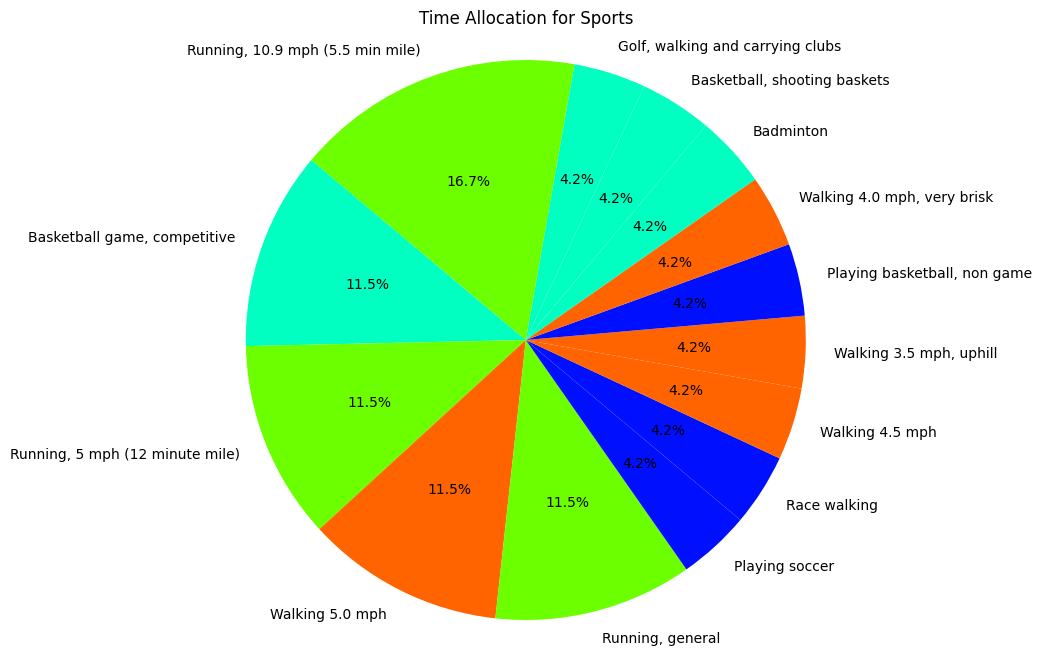

In [254]:
update_dict = x_moderate_result | x_high_result

filtered_activities = {sport: time for sport, time in update_dict.items() if time >= 0.1}

# Extract labels and sizes for the pie chart
labels = list(filtered_activities.keys())
sizes = list(filtered_activities.values())

# Define a color palette
palette = sns.color_palette("hsv", len(labels))
# Assign similar colors based on activity keywords
color_map = {}
for label in labels:
    if "Walking" in label:
        color_map[label] = palette[0]
    elif "Running" in label:
        color_map[label] = palette[3]
    elif "Soccer" in label or "Basketball" in label or "Badminton" in label or "Golf" in label:
        color_map[label] = palette[6]
    else:
        color_map[label] = palette[9]

# Create the pie chart
plt.figure(figsize=(10, 8))
plt.pie(sizes, labels=labels, colors=[color_map[label] for label in labels], autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Time Allocation for Sports')
plt.show()

In [255]:
initial_lp = cal_l*x_l.value + cal_m*x_m.value + cal_h*x_h.value - c.value
fine_tuned_lp = cal_l*x_l.value + mod_high_general - c.value

# Combine the print statements
print(f"Initial LP optimization: {initial_lp}")
print(f"Fine tuned LP optimization: {fine_tuned_lp}")
print(f"We've made an improvement of extra {fine_tuned_lp - initial_lp} calories burning")

Initial LP optimization: 1958.095107486019
Fine tuned LP optimization: 2600.1712557009887
We've made an improvement of extra 642.0761482149696 calories burning


Now we've made an optimized plan for `exercise` generally.

The only thing we need to do now is to make a `diet combo` that could reach **BMR** since the LP result tells us that merely reaching it can maximize our result of purpose.

Based on [healthy eating plate](https://www.hsph.harvard.edu/nutritionsource/healthy-eating-plate/), we will set our constraints.

In [256]:
# keywords for filtering each category
whole_grain_main_food_keywords = ["whole", "rice", "noodle"] # We add rice and noodle in case 
                                                             # there are too few options for the actual whole grain.
protein_keywords_updated = ["fish", "poultry", "beans", "nuts", "meat"]
exclude_protein_keywords = ["bacon", "cold cuts", "red meat", "cheese", "hamburger", "smoke", "corned", "Pot-pie", "Ham"]

# Clean data
nutrients_data = nutrients_data[nutrients_data['Calories'] > 0]

# Filtering for Whole Grains and Main Food
whole_grains_main_food = nutrients_data[nutrients_data['Food'].str.contains('|'.join(whole_grain_main_food_keywords), case=False, na=False)]

# Filtering for Proteins, including and excluding certain items
proteins_updated = nutrients_data[(nutrients_data['Food'].str.contains('|'.join(protein_keywords_updated), case=False, na=False) | 
                        nutrients_data['Category'].str.contains('|'.join(protein_keywords_updated), case=False, na=False)) &
                        ~nutrients_data['Food'].str.contains('|'.join(exclude_protein_keywords), case=False, na=False) &
                        ~nutrients_data['Category'].str.contains('|'.join(exclude_protein_keywords), case=False, na=False)]

# For Vegetables and Fruits, we would normally exclude potatoes and French fries.
vegetables_fruits = nutrients_data[(nutrients_data['Category'].str.contains("vegetables|fruits", case=False, na=False)) &
                         ~nutrients_data['Food'].str.contains("potatoes|french fries", case=False, na=False)]

whole_grains_main_food, proteins_updated, vegetables_fruits

(              Food  Measure Grams  Calories Protein Fat Sat.Fat Fiber Carbs  \
 225    Whole-wheat  1 slice    23      55.0       2   1       0  0.31    11   
 235  Wheat (whole)    1 cup   120     390.0      13   2       0   2.8    79   
 239        Noodles    1 cup   160     200.0       7   2       2   0.1    37   
 245    Puffed rice    1 cup    14      55.0       t   t       0     t    12   
 247           Rice    1 cup   208     748.0      15   3       0   1.2   154   
 250    Rice flakes    1 cup    30     115.0       2   t       0   0.1    26   
 251    Rice polish  1/2 cup    50     132.0       6   6       0   1.2    28   
 254    whole-wheat        1    40     102.0       4   1       0   0.1    20   
 257   Spanish rice    1 cup   250     217.0       4   4       0  1.20    40   
 270         Noodle    1 cup   250     115.0       6   4       3  0.20    13   
 
                              Category  
 225  Breads, cereals, fastfood,grains  
 235  Breads, cereals, fastfood,grai

In [265]:
# Dataframes prepared earlier
whole_grains_df = whole_grains_main_food
proteins_df = proteins_updated
vegetables_fruits_df = vegetables_fruits

# Converting measure to grams (assuming '1 slice' as 50g, '1 cup' as 250g, etc.)
conversion_factors = {'slice': 50, 'cup': 250, 'loaf': 454, 'steak': 100, 'oz.': 28.35}
for df in [whole_grains_df, proteins_df, vegetables_fruits_df]:
    # Ensure 'Measure' to 'Grams' conversion is applied correctly
    df['Grams'] = df['Measure'].map(conversion_factors).fillna(df['Grams'])
    # Convert 'Grams' to float, handling non-numeric gracefully
    df['Grams'] = pd.to_numeric(df['Grams'], errors='coerce')
    # Fill NaN values in 'Grams' with a reasonable default if any are still missing
    df['Grams'].fillna(100, inplace=True)  # Assuming 100g as a default where conversion is unknown

    # Convert 'Calories' to numeric, assuming any non-numeric is coerced to NaN
    df['Calories'] = pd.to_numeric(df['Calories'], errors='coerce')
    # Fill NaN values in 'Calories'
    df['Calories'].fillna(df['Calories'].mean(), inplace=True)  # Replace NaN with the mean of the column

    # Calculate 'Calories per 100g'
    df['Calories per 100g'] = (df['Calories'] / df['Grams']) * 100

# Variables for each food item
x_whole = cp.Variable(len(whole_grains_df), nonneg=True)
x_protein = cp.Variable(len(proteins_df), nonneg=True)
x_veg_fruit = cp.Variable(len(vegetables_fruits_df), nonneg=True)

# Total calories
calories_whole = whole_grains_df['Calories per 100g'].values @ x_whole
calories_protein = proteins_df['Calories per 100g'].values @ x_protein
calories_veg_fruit = vegetables_fruits_df['Calories per 100g'].values @ x_veg_fruit
total_calories = calories_whole + calories_protein + calories_veg_fruit

# Binary variables for each food item to enforce selection limits
select_whole = cp.Variable(len(whole_grains_df), boolean=True)
select_protein = cp.Variable(len(proteins_df), boolean=True)
select_veg_fruit = cp.Variable(len(vegetables_fruits_df), boolean=True)


# Simplified Objective: Minimize total calorie intake as a basic test
objective = cp.Minimize(total_calories)

# Total food quantity
total_quantity = cp.sum(x_whole) + cp.sum(x_protein) + cp.sum(x_veg_fruit)
min_quantity = 1.5 

# Proportional constraints
constraints = []

constraints += [
    total_calories >= 1650,
    total_calories <= 2000
]

constraints += [
    cp.sum(x_whole) == 0.25 * total_quantity,
    cp.sum(x_protein) == 0.25 * total_quantity,
    cp.sum(x_veg_fruit) == 0.50 * total_quantity
]

constraints += [
    x_whole <= 1000 * select_whole,
    x_protein <= 1000 * select_protein,
    x_veg_fruit <= 1000 * select_veg_fruit,
    cp.sum(select_whole) <= 7,
    cp.sum(select_whole) >= 4,
    cp.sum(select_protein) <= 7,
    cp.sum(select_protein) >= 4,
    cp.sum(select_veg_fruit) <= 7,
    cp.sum(select_veg_fruit) >= 4
]

constraints += [
    x_whole >= min_quantity * select_whole,
    x_protein >= min_quantity * select_protein,
    x_veg_fruit >= min_quantity * select_veg_fruit
]


# Re-solve with caloric constraints
problem = cp.Problem(objective, constraints)
result = problem.solve()

# Function to extract selected items
def extract_selected_items(df, quantities, selection):
    selected_items = [(df.iloc[i]['Food'], quantities[i]) for i in range(len(df)) if selection[i] > 0.1]  # Threshold to consider selection
    return selected_items

# Check the results with the new constraints
if problem.status == "optimal":
    print("Optimal solution found with item limits.")
    selected_whole_grains = extract_selected_items(whole_grains_df, x_whole.value, select_whole.value)
    selected_proteins = extract_selected_items(proteins_df, x_protein.value, select_protein.value)
    selected_veg_fruits = extract_selected_items(vegetables_fruits_df, x_veg_fruit.value, select_veg_fruit.value)
    print("Selected Whole Grains:", selected_whole_grains)
    print("Selected Proteins:", selected_proteins)
    print("Selected Vegetables and Fruits:", selected_veg_fruits)
    print("Total calories:", total_calories.value)
else:
    print("Model status with item limits:", problem.status)

Optimal solution found with item limits.
Selected Whole Grains: [('Noodles', 1.5), ('Rice polish', 1.5), ('Spanish rice', 1.7241067230699134), ('Noodle', 1.5)]
Selected Proteins: [('Clams', 1.5), ('Crab meat', 1.5), ('Scallops', 1.7241067230699134), ('Beans', 1.5)]
Selected Vegetables and Fruits: [('Eggplant', 7.948213446139826), ('Fruit cocktail, canned', 1.5), ('Grapefruit juice', 1.5), ('Watermelon', 1.5)]
Total calories: 1650.0


C:\Users\rocky\AppData\Local\Temp\ipykernel_20324\3934099171.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Grams'] = df['Measure'].map(conversion_factors).fillna(df['Grams'])
C:\Users\rocky\AppData\Local\Temp\ipykernel_20324\3934099171.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Grams'] = pd.to_numeric(df['Grams'], errors='coerce')
C:\Users\rocky\AppData\Local\Temp\ipykernel_20324\3934099171.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

Based on the adjustment of personal difined diversity and balance, it will adjust accordingly.